

# <center>Анализ алгоритма<a style='color:red'> SSD </a> 
#### <center><a style='color:red'>  Single Shot Detector </a> 


___
<a id=100>Содержание</a>
- [Ключевые особенности алгоритма](#1)
- [Основные этапы алгоритма](#2)
    - [Базовая нейронная сеть](#3)
    - [Дополнительные слои SSD](#4)
    - [Слои сверток предсказаний SSD](#5)
    - [Функция потерь](#6)
- [Пример использования](#7)
- [Преимущества и недостатки SSD](#8)
- [Использованные источники](#9)

___
## <center><a id=1 style='color:red'>Ключевые особенности алгоритма</a>

`SSD` (Single Shot Detector) — это тип нейронной сети, который используется для детекции объектов на изображениях.  
SSD использует одноэтапный процесс, что делает его более быстрым и эффективным. Она способна работать с различными размерами входных изображений и обеспечивает высокую точность детекции при относительно низкой вычислительной сложности.  
Архитектуру SSD можно условно разделить на три части: 
- $\boxed{1}$  Первая часть - `базовая` нейронная сеть для классификации изображений, предоставляющая две карты признаков. В качестве нейронной сети можно взять VGG или ResNet

- $\boxed{2}$  Вторая часть - `дополнительные` слои свертки, выходами которой являются четыре карты признаков различных размеров .

- $\boxed{3}$  Вторая часть - `слои сверток предсказаний`, предсказывающая из карт признаков координаты контура объектов и класс объектов.

`Архитектура` SSD:

<img src='data/img/ssd.png'> 


___
## <center><a id=2 style='color:red'>Основные этапы алгоритма</a>


### <center><a id=3 >1. Базовая нейронная сеть</a>

В качестве первых слоев SSD используются слои нейронных сетей, ипользуемые для задач классификации, в частности может быть использована архитектура `VGG-16`.  
Первые слои SSD -  первые 4 сверточных слоя `VGG-16`, которые преобразуют исходное изображение в карты признаков.

`Карта признаков` - выходной тензор сверточного слоя, который содержит информацию о признаках изображения. Глубина карты признаков соответсвует числу фильтров предшествовавшего сверточного слоя.

Иллюстрация работы сверточного слоя с одним фильтром и изображением с одним каналом:

<img src='data/img/fm.webp'> 

На рисунке слева на право:
- Тензор исходного изображения
- Сверточный фильтр
- Карта признаков

<a>Сверточные слои</a> состоят из сверточных слоев, функции активации ReLU и макс пулинга:

- `Слои свертки `последовательно применяются и имеют размер ядра 3х3, шаг 1 и паддинг 1, что сохраняет размер входящего тензора.

- `Макс пулинг` имеет размер окна 2х2 и шаг 2, уменьшая входящий тензор в два раза.

Последний блок слоев выхода VGG-16 заменяется на дополнительные сверточные слои.

<a>Выходные данные</a> базовой сети являются две карты признаков:
- `38х38х512`

- `19х19х1024`

`Архитектура базовой сети`:

<img src='data/img/ssd-b.png'> 



In [3]:
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class VGGBase(nn.Module):

    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

    def forward(self, image):


        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))  # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        return conv4_3_feats, conv7_feats

model = VGGBase().to(device)
summary(model, (3,300,300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,792
            Conv2d-2         [-1, 64, 300, 300]          36,928
         MaxPool2d-3         [-1, 64, 150, 150]               0
            Conv2d-4        [-1, 128, 150, 150]          73,856
            Conv2d-5        [-1, 128, 150, 150]         147,584
         MaxPool2d-6          [-1, 128, 75, 75]               0
            Conv2d-7          [-1, 256, 75, 75]         295,168
            Conv2d-8          [-1, 256, 75, 75]         590,080
            Conv2d-9          [-1, 256, 75, 75]         590,080
        MaxPool2d-10          [-1, 256, 38, 38]               0
           Conv2d-11          [-1, 512, 38, 38]       1,180,160
           Conv2d-12          [-1, 512, 38, 38]       2,359,808
           Conv2d-13          [-1, 512, 38, 38]       2,359,808
        MaxPool2d-14          [-1, 512,

### <center><a id=4 >2. Дополнительные слои SSD</a>

К слоям базовой сети добавляются дополнительные свертоные слои, состоящие из слоев свертки и функции активации ReLU.  
После каждого блока сверточных слоев выходит карта признаков, постепенно уменьшающегося размера и ,тем самым, каждая клетка карты признаков охватывает все большую область исходного изображения.

<a>Сверточные слои</a> состоят из слоев всертки и функции активации ReLU:

- `Слои свертки `последовательно применяются и имеют размер ядра 1х1 и 3х3. Для ядра 1х1 паддинг отсутствует, для ядра 3х3 паддинг имеет размер 1.

<a>Выходные данные</a> дополнительных слоев карты признаков:

- `10х  0х512`

- `5х5х256`
- `3х3х256`
- `1х1х256`

`Архитектура дополнительных слоев`:

<img src='data/img/ssd-a.png' width=600> 


In [5]:
class AuxiliaryConvolutions(nn.Module):

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)  # stride = 1, by default
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        self.init_conv2d()

    def init_conv2d(self):

        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv7_feats):

        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = F.relu(self.conv9_1(out))  # (N, 128, 10, 10)
        out = F.relu(self.conv9_2(out))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = F.relu(self.conv10_1(out))  # (N, 128, 5, 5)
        out = F.relu(self.conv10_2(out))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = F.relu(self.conv11_1(out))  # (N, 128, 3, 3)
        conv11_2_feats = F.relu(self.conv11_2(out))  # (N, 256, 1, 1)

        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats

model = AuxiliaryConvolutions().to('cuda:0')
summary(model, ( 1024, 19,19))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 19, 19]         262,400
            Conv2d-2          [-1, 512, 10, 10]       1,180,160
            Conv2d-3          [-1, 128, 10, 10]          65,664
            Conv2d-4            [-1, 256, 5, 5]         295,168
            Conv2d-5            [-1, 128, 5, 5]          32,896
            Conv2d-6            [-1, 256, 3, 3]         295,168
            Conv2d-7            [-1, 128, 3, 3]          32,896
            Conv2d-8            [-1, 256, 1, 1]         295,168
Total params: 2,459,520
Trainable params: 2,459,520
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.41
Forward/backward pass size (MB): 1.29
Params size (MB): 9.38
Estimated Total Size (MB): 12.09
----------------------------------------------------------------


### <center><a id=5 >3. Слои сверток предсказаний SSD</a>

Слои сверток предсказаний принимают на вход 6 карт признаков из предыдущих слоев, к которым применяются сверточные слои для предсказания вероятности нахождения объекта определенного класса и его координаты: координаты центра объекта, его ширина и высота.

<a>Сверточные слои для определения координат</a> состоят из слоев свертки с размером ядра 3х3, падингом 1, в результате чего входящий размер карты признаков остается прежним. Число каналов, применяемых для каждой карты признаков определяется количеством предсказываемых координат - 4 ( $x_{center}$, $y_{center}$, $W$, $H$ ) и количеством якорных контуров.

`Якорный контур` (Anchor boxes) — это прямоугольные области на изображении, которые используются для обнаружения объектов. Они имеют разные размеры и соотношения сторон, что позволяет обнаруживать объекты разных форм и размеров.

Алгоритм SSD использует несколько уровней anchor boxes с разными размерами и соотношениями сторон. Это позволяет обнаруживать объекты на разных масштабах и в разных частях изображения.

Якорные контуры:

<img src='data/img/ab.png' width=400> 

Количество якорных контуров для каждой карты признаков:
| Карта признаков | Количество якорных контуров на ячейку| Общее количество якорных контуров |
|:-:|:-:|:-:|
| 38х38 | 4 | 5776|
|19х19 | 6| 2166 |
|10х10 | 6| 600|
|5х5 |6 |150 |
|3х3 |4 | 36 |
| 1х1|4 |4 |

<a>Выходные данные</a> сверточных слоев для определения координат - карта признаков размером 8732х4, где:
- 4: координаты объекта
- 8732: ячейки для всех карт признаков, поданных на вход сверточных слоев для определения координат

<a>Сверточные слои для определения класса объекта</a> состоят из слоев свертки с размером ядра 3х3, падингом 1, в результате чего входящий размер карты признаков остается прежним. Число каналов, применяемых для каждой карты признаков определяется количеством классов объектов и количеством якорных контуров.

<a>Выходные данные</a> сверточных слоев для определения класса объекта - карта признаков размером 8732хK, где:
- K: количество классов объекта
- 8732: ячейки для всех карт признаков, поданных на вход сверточных слоев для определения наличия объекта

### <center><a id=6 >4. Функция потерь</a>

Функция потерь для детекции является суммой функции потерь для определения `координат` и функции потерь для определения `класса` объекта.

Выходы сверточного слоя для определения координат являются координатами предсказанных контуров объектов. В функцию потерь подаются предварительно отфильтрованные предсказанные контуры:

$\boxed{1}$ Для предсказанных контуров рассчитывается `IoU` между размеченными (действительными) контурами объектов.
 
$\boxed{2}$ Каждый предсказанный контур `присваивается к классу`, к которому относится действительный контур с наибольшим значением `IoU` для этого предсказанного контура.

$\boxed{3}$ Предсказанные контуры со значением `IoU` меньше порогового (0.5) исключаются из ранее присвоенного класса и присваивается класс "без объекта".

Значения координат отфильтрованных контуров, с IoU больше , чем порог (0.5), подаются в <a>функцию потерь для определения координат</a>:

$\boxed{L_{loc} = \frac{1}{n_{pos}} \sum_{i \in{x,y,w,h}} Smooth_{L_1}(l_i^{pos} - g_i^{pos}) }$, где:

- $pos$ : отфильтрованные на предыдущем шаге контуры
- $l_i^{pos}$: предсказанные контуры
- $g_i^{pos}$: действительные контуры

- $Smooth_{L_1}(x)$: $\begin{cases} 0.5 \cdot x^2, |x| < 1\\ |x| - 0.5, |x| \ge 1\\\end{cases}$

Значения присвоенных классов для предсказанных контуров помещаются в <a>функцию потерь для определения класса</a>:

$\boxed{L_{conf} = -\sum_{i \in{pos}} x^p_i \cdot \log (p_i^p)- \sum_{i \in{neg}} \log (p_i^0) }$, где:

- $pos$ : отфильтрованные на предыдущем шаге контуры

- $neg$ : контуры с классом "без объекта", с наибольшей ошибочной уверенностью отнесения к классу объекта. Общее количество регулируется соотношением 3 $neg$ к 1 $pos$, т.к. $pos$ контуров  намного меньше $neg$ контуров.

- $p_i^p$: вероятность, выданная нейронной сетью после применения функции активации softmax:
    - $\boxed{p_i^p = \frac{\exp(c_i)}{\sum_p \exp(c_i)}}$, где
        - $c_i$: выходы сверточных слоев для определения класса объекта

<a>Функция потерь для детекции</a> определяется формулой:

$\boxed{ L_{conf} + \alpha \cdot L_{loc}}$, где:
- $\alpha$ : весовой коэффициент функции потерь определения координат

После прохождения  обучения нейронной сети производитя финальный этап - Non-Maximum Suppression.

<a id='nms'>Non-Maximum Suppression</a> удаляет прямоугольные контуры лиц, которые дублируются и накладываются друг на друга,оставляя только один контур с наибольшей уверенностью предсказания.

$\boxed{1}$ Для предсказанных контуров рассчитывается IoU `между собой`.

$\boxed{2}$ Из контуров с большим значением IoU оставляется контур с `наибольшей` уверенностью предсказания.


___
## <center><a id=7 style='color:red'>Пример использования</a>

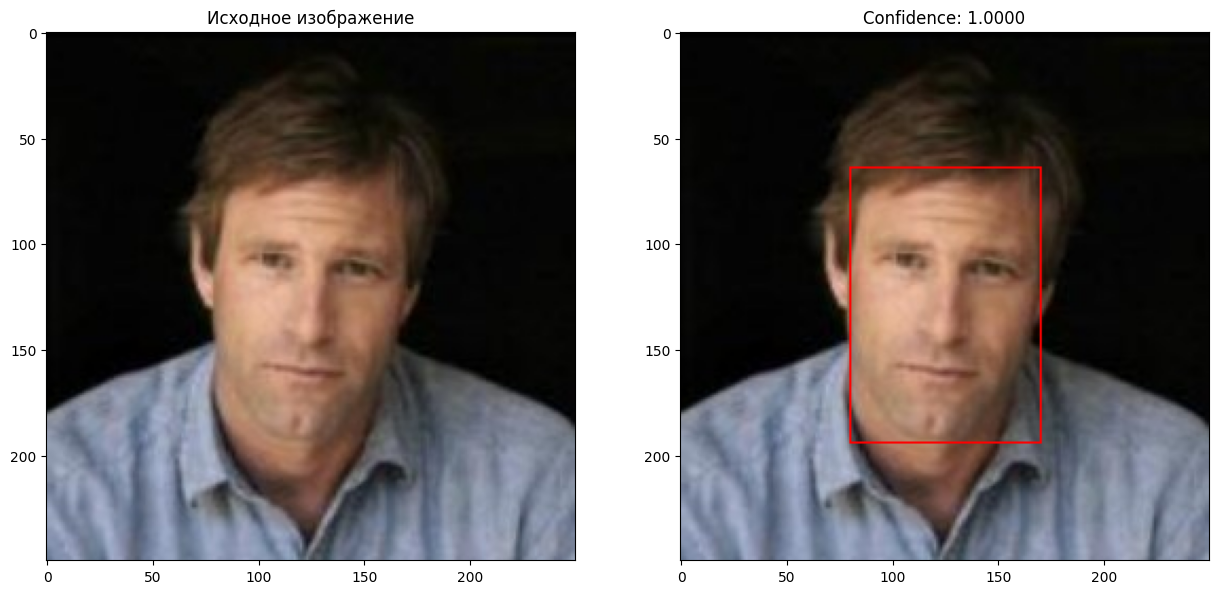

In [67]:
from deepface import DeepFace
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np


def get_box(results: list) -> list:
    x = results[0]['facial_area']['x']
    y = results[0]['facial_area']['y']
    width = x + results[0]['facial_area']['w']
    higth =y + results[0]['facial_area']['h']
    return [x, y, width, higth]

img_path = 'data/Aaron_Eckhart/Aaron_Eckhart_0001.jpg'
img = Image.open(img_path)
img_detected = img.copy()

draw = ImageDraw.Draw(img_detected)
face = DeepFace.extract_faces(img_path, detector_backend='ssd')
fig, ax = plt.subplots(1,2, figsize=(15,8))
draw.rectangle(get_box(face), outline=(255,0,0))

ax[0].imshow(img)
ax[1].imshow(img_detected);
ax[0].set_title('Исходное изображение')
ax[1].set_title(f'Confidence: {face[0]["confidence"]:.4f}');

___
## <center><a id=8 style='color:red'>Преимущества и недостатки SSD</a>

<center><a>Преимущества</a></center>

- `Скорость работы`. Метод позволяет быстро обнаруживать лица на изображениях. Это особенно полезно при работе с видеопотоком или в реальном времени.

- `Простота реализации`. Метод имеет относительно простую архитектуру, что делает его легко реализуемым.

- `Возможность обучения на небольших наборах данных`. Метод может быть обучен на небольших наборах данных, что делает его подходящим для задач, где данные ограничены.

<center><a>Недостатки</a></center>

- `Ограниченная точность`. Метод может не обеспечивать такую же точность обнаружения, как более сложные методы.

- `Сложность настройки`. Метод требует тщательной настройки гиперпараметров для достижения оптимальной производительности. В частности параметры якорных контуров, весовой коэффициент функции потерь для определения координат.

- `Ограниченное использование для сложных сцен`. Метод может испытывать трудности при обнаружении объектов в сложных сценах с большим количеством объектов или с перекрывающимися объектами.

___
## <center><a id=9 style='color:red'>Использованные источники</a>

| Ссылка|Краткое описание |
|-|-| 
|[SSD GitHub](https://github.com/weiliu89/caffe/tree/ssd) | Описание алгоритма |
| [Single Shot Detector (SSD) + Architecture of SSD](https://iq.opengenus.org/single-shot-detector/)|Краткое писание алгоритма |
|[amdegroot GitHub](https://github.com/amdegroot/ssd.pytorch/blob/5b0b77faa955c1917b0c710d770739ba8fbff9b7/ssd.py#L10) |Pytorch код алгоритма |
| [facef PyPI](https://pypi.org/project/facef/)| Библиотека для имплементации SSD|
| [HaiNguyen2903 GitHub](https://github.com/HaiNguyen2903/Single-Shot-Detector/blob/master/model.py)| Pytorch код алгоритма|
|[Обнаружение объектов. SSD. Лекция 8. Компьютерное зрение с использованием DL](https://www.youtube.com/watch?v=C9ZGQfE0XPQ) |Описание алгоритма |
|[Лекция. Нейронная детекция объектов. Одностадийные нейросети.](https://www.youtube.com/watch?v=OPK63uqAQLs) | Описание алгоритма|
|[SSD tutorial GitHub](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection#implementation) |Описание алгоритма |